In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [48]:
!pip install torch datasets torchmetrics tokenizers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
import torch 
import torch.nn as nn
import math 
from types import SimpleNamespace


In [50]:
class InputEmbedding(nn.Module):
    def __init__(self,d_model:int,vocab_size:int):
        super().__init__()
        self.d_model=d_model
        self.vocab_size=vocab_size
        self.embeddings=nn.Embedding(vocab_size,d_model)
    def forward(self,x):
        return self.embeddings(x)*math.sqrt(self.d_model)
class PositionalEncoding(nn.Module):
    def __init__(self,d_model:int,seq_len:int,dropout:float):    
        super().__init__()
        self.d_model=d_model
        self.seq_len=seq_len
        self.dropout=nn.Dropout(dropout)
        pe=torch.zeros(seq_len,d_model)
        pos=torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1)
        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(pos*div_term)
        pe[:,1::2]=torch.cos(pos*div_term)
        #so we apply sin to even and cose to odd terms to get the size of seq_len,d_model
        pe=pe.unsqueeze(0)#this accounts for the batch size 
        self.register_buffer('pe',pe)
    def forward(self,x):
        x=x+(self.pe[:,:x.shape[1],:]).requires_grad_(False)
        return self.dropout(x)
class LayerNormalisation(nn.Module):
    def  __init__(self,features:int,eps:float=10**-6):
        super().__init__()
        self.eps=eps
        self.alpha=nn.Parameter(torch.ones(features))
        self.bias=nn.Parameter(torch.zeros(features))
    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        std=x.std(dim=-1,keepdim=True)
        return self.alpha*(x-mean)/(std+self.eps)+self.bias
class FeedForward(nn.Module):
    def __init__(self,d_model:int,d_ff:int,dropout:float):
        super().__init__()
        self.linear_1=nn.Linear(d_model,d_ff)
        self.dropout=nn.Dropout(dropout)
        self.linear_2=nn.Linear(d_ff,d_model)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.linear_2(self.dropout(self.relu(self.linear_1(x))))
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self,d_model:int,h:int,dropout:float):
        super().__init__()
        self.d_model=d_model
        self.h=h
        assert d_model%h==0,"d_model is not divisible by h "
        self.d_k=d_model//h
        self.w_k=nn.Linear(d_model,d_model)
        self.w_q=nn.Linear(d_model,d_model)
        self.w_v=nn.Linear(d_model,d_model)
        self.w_o=nn.Linear(d_model,d_model)
        self.dropout=nn.Dropout(dropout)
    @staticmethod
    def attention(query,key,value,mask,dropout:float):
        d_k=query.shape[-1]
        attention_score=(query@key.transpose(-2,-1))/math.sqrt(d_k)
        if mask is not None:
            attention_score.masked_fill_(mask==0,-1e9)
        attention_score=attention_score.softmax(dim=-1)
        if dropout is not None:
            attention_score=dropout(attention_score)
        return (attention_score@value),attention_score
    def forward(self,q,k,v,mask):
        query=self.w_q(q)
        key=self.w_k(k)
        value=self.w_v(v)
        #query goes from (batch ,seq ,d_m)->(batch,h,seq,d_k)
        query=query.view(query.shape[0],-1,self.h,self.d_k).transpose(1,2)
        key=key.view(key.shape[0],-1,self.h,self.d_k).transpose(1,2)
        value=value.view(key.shape[0],-1,self.h,self.d_k).transpose(1,2)
        x,self.attention_score=MultiHeadAttentionBlock.attention(query,key,value,mask,self.dropout)
        x=x.transpose(1,2).contiguous().view(x.shape[0],-1,self.h*self.d_k)
        return self.w_o(x)
class ResidualConnection(nn.Module):
    def __init__(self,features:int,dropout:float):
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNormalisation(features)
    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))
class EncoderBlock(nn.Module):
    def __init__(self,d_model:int,self_attention_block:MultiHeadAttentionBlock,feed_forward_block:FeedForward,dropout:float):
        super().__init__()
        self.self_attention_block=self_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual=nn.ModuleList([ResidualConnection(d_model,dropout) for _ in range(2)])
    def forward(self,x,src_mask):
        x=self.residual[0](x,lambda x:self.self_attention_block(x,x,x,src_mask))
        x=self.residual[1](x,lambda x : self.feed_forward_block(x))
        return x
class Encoder(nn.Module):
    def __init__(self,features:int,layers:nn.ModuleList):
        super().__init__()
        self.layers=layers
        self.norm=LayerNormalisation(features)
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)
class DecoderBlock(nn.Module):
    def __init__(self,d_model:int,self_attention_block:MultiHeadAttentionBlock,cross_attention_block:MultiHeadAttentionBlock,feed_forward_block:FeedForward,dropout:float):
        super().__init__()
        self.self_attention_block=self_attention_block
        self.cross_attention_block=cross_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual=nn.ModuleList([ResidualConnection(d_model,dropout) for _ in range(3)])
    def forward(self,x,encoder_output,src_mask, tgt_mask):
        x=self.residual[0](x,lambda x:self.self_attention_block(x,x,x,tgt_mask))
        x=self.residual[1](x,lambda x:self.cross_attention_block(x,encoder_output,encoder_output,src_mask))
        x=self.residual[2](x,lambda x:self.feed_forward_block(x))
        return x
class Decoder(nn.Module):
    def __init__(self,features:int,layers:nn.ModuleList):
        super().__init__()
        self.layers=layers
        self.norm=LayerNormalisation(features)
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,encoder_output,src_mask,tgt_mask)
        return self.norm(x)    

In [51]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model:int ,vocab_size :int):
        super().__init__()
        self.proj=nn.Linear(d_model,vocab_size)
    def forward(self,x):
        return torch.log_softmax(self.proj(x),dim=-1)

In [52]:

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbedding, tgt_embed: InputEmbedding, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) 
        tgt = self.tgt_pos(tgt) 
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)
    def forward(self,src,tgt,src_mask,tgt_mask):
        encoder_output=self.encode(src,src_mask)
        decoder_output=self.decode(encoder_output,src_mask,tgt,tgt_mask)
        project_output=self.project(decoder_output)
        return project_output

def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    src_embed = InputEmbedding(d_model, src_vocab_size)
    tgt_embed = InputEmbedding(d_model, tgt_vocab_size)
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForward(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    encoder = Encoder(d_model,nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model,nn.ModuleList(decoder_blocks))
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p) 
    return transformer

In [53]:
#to do i must load the dataset adn then train the tokenizer and the model as well

In [54]:
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
print(" Downloading dataset...")
dataset = load_dataset("google/code_x_glue_cc_code_to_code_trans",split="train")
print(f"Data loaded. Found {len(dataset)} examples.")

def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        chunk = dataset[i : i + 1000]
        for text in chunk['java']:
            yield text
        for text in chunk['cs']:
            yield text
print("Building Tokenizer...")
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(
    vocab_size=30000, 
    special_tokens=["[PAD]", "[SOS]", "[EOS]", "[UNK]"]
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)
tokenizer.save("java2cs_tokenizer.json")
print("Tokenizer built and saved!")
print(tokenizer.encode('int main').ids)

Data loaded. Found 10300 examples.
Building Tokenizer...



Tokenizer built and saved!
[172, 698]


In [55]:
import torch 
from torch.utils.data import Dataset, DataLoader

class java2csDataset(Dataset):
    def __init__(self, ds, tokenizer, max_lenght=256):
        super().__init__()
        self.ds = ds
        self.tokenizer = tokenizer
        self.max_lenght = max_lenght
        self.sos_token = tokenizer.token_to_id('[SOS]')
        self.eos_token = tokenizer.token_to_id('[EOS]')
        self.pad_token = tokenizer.token_to_id('[PAD]')

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        java_text = self.ds[idx]['java']
        cs_text = self.ds[idx]['cs']
        
        src_ids = self.tokenizer.encode(java_text).ids
        tgt_ids = self.tokenizer.encode(cs_text).ids
        
        src_tensor = [self.sos_token] + src_ids + [self.eos_token]        
        tgt_tensor = [self.sos_token] + tgt_ids + [self.eos_token]

        pad_len_src = self.max_lenght - len(src_tensor)
        pad_len_tgt = self.max_lenght - len(tgt_tensor)

        if pad_len_src > 0: 
            src_tensor = src_tensor + ([self.pad_token] * pad_len_src)
        if pad_len_tgt > 0: 
            tgt_tensor = tgt_tensor + ([self.pad_token] * pad_len_tgt)

        if pad_len_src < 0: 
            src_tensor = src_tensor[:self.max_lenght]
        if pad_len_tgt < 0: 
            tgt_tensor = tgt_tensor[:self.max_lenght]

        return {
            "java": torch.tensor(src_tensor, dtype=torch.long),
            "cs": torch.tensor(tgt_tensor, dtype=torch.long)
        }

In [56]:
ds_train=java2csDataset(dataset,tokenizer)
train_loader=DataLoader(ds_train,batch_size=32,shuffle=True)


In [57]:
batch = next(iter(train_loader))
print(f"Shape of Source Batch: {batch['java'].shape}") # Should be [32, 128]
first_sample = batch['java'][0]
print(first_sample[:20]) 
clean_ids = [id for id in first_sample.tolist() if id != tokenizer.token_to_id("[PAD]")]
print(tokenizer.decode(clean_ids))

Shape of Source Batch: torch.Size([32, 256])
tensor([   1,  149,  172, 2880,  198,   93,  154,  652,   17,  384,   16, 1272,
         185,    2,    0,    0,    0,    0,    0,    0])
public int available () { return data . length - ptr ;}


In [58]:
model = build_transformer(
    src_vocab_size=vocab_len, 
    tgt_vocab_size=vocab_len,
    src_seq_len=256,
    tgt_seq_len=256,
    d_model=256,  
    N=2,         
    h=4,          
    dropout=0.1,
    d_ff=512    
)

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
pad_token_id = tokenizer.token_to_id("[PAD]")
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
print("Model, Loss, and Optimizer are ready!")

Using device: cuda
Model, Loss, and Optimizer are ready!


In [64]:
import torch
import torch.nn as nn
from tqdm import tqdm 
import os
def causal_mask(size):
    mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
    return mask == 0
def create_masks(src, tgt, device):
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2).int().to(device)
    tgt_seq_len = tgt.shape[1]
    tgt_causal_mask = causal_mask(tgt_seq_len).to(device)
    tgt_padding_mask = (tgt != 0).unsqueeze(1).unsqueeze(2).int().to(device)
    tgt_mask = tgt_causal_mask & tgt_padding_mask
    return src_mask, tgt_mask
def train_model(model, train_loader, optimizer, loss_fn, device, num_epochs):
    model.to(device)
    model.train() #
    print(f" Starting training on {device}...")
    
    for epoch in range(num_epochs):
        batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0
        for batch in batch_iterator:
            encoder_input = batch['java'].to(device) 
            tgt = batch['cs'].to(device)           
            decoder_input = tgt[:, :-1]
            ground_truth = tgt[:, 1:]
            src_mask, tgt_mask = create_masks(encoder_input, decoder_input, device)
            optimizer.zero_grad()
            proj_output = model(encoder_input, decoder_input, src_mask, tgt_mask)
            # Flatten: (Batch * Seq_Len, Vocab_Size) vs (Batch * Seq_Len)
            loss = loss_fn(
                proj_output.view(-1, proj_output.shape[-1]), 
                ground_truth.contiguous().view(-1)
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f" Epoch {epoch+1} Complete | Average Loss: {avg_loss:.4f}")
    model_filename = f"java2cs_model+.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, model_filename)
    print(f"Saved checkpoint: {model_filename}")

train_model(
    model=model, 
    train_loader=train_loader, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    device=device, 
    num_epochs=30
)

 Starting training on cuda...


Epoch 1/30:  55%|█████▍    | 177/322 [00:52<00:42,  3.37it/s, loss=2.127]


KeyboardInterrupt: 

In [67]:
java_code_clean = "public static void main(String[] args) { int a = 10; int b = 20; int sum = a - b; System.out.println(sum); }"
def translate_robust(model, sentence, tokenizer, max_len=256, device='cuda'):
    model.eval()
    input_ids = tokenizer.encode(sentence).ids
    src = torch.tensor(input_ids).unsqueeze(0).to(device)
    
    sos_token = tokenizer.token_to_id("[SOS]")
    eos_token = tokenizer.token_to_id("[EOS]")
    
    tgt = torch.tensor([[sos_token]]).to(device)
    
    for _ in range(max_len):
        src_mask, tgt_mask = create_masks(src, tgt, device)
        
        with torch.no_grad():
            output = model(src, tgt, src_mask, tgt_mask)
            logits = output[:, -1, :]
            if tgt.size(1) > 1:
                last_token = tgt[0, -1]
                logits[0, last_token]=-float('inf') # Penalize repetition
            
            next_token_id = logits.argmax()
            
            if next_token_id.item() == eos_token:
                break
            tgt = torch.cat([tgt, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)
    return tokenizer.decode(tgt[0].tolist()[1:])
print("Original Input: ", java_code_clean)
print("-" * 30)
output = translate_robust(model, java_code_clean, tokenizer, device=device)
print("C# Output:", output)

Original Input:  public static void main(String[] args) { int a = 10; int b = 20; int sum = a - b; System.out.println(sum); }
------------------------------
C# Output: public static void Main ( string [] args ){ int a = 10 ; int b = 20 ; int i = a - b . Length ; }


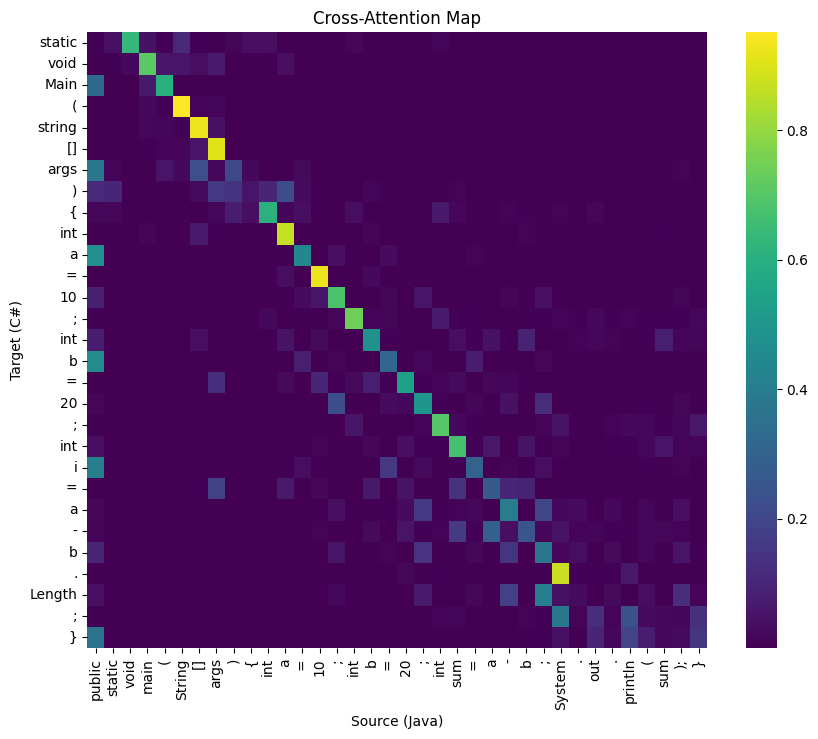

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, tokenizer, java_code, translation, device):
    model.eval()
    if hasattr(model, 'module'):
        real_model = model.module
    else:
        real_model = model

    source_ids = tokenizer.encode(java_code).ids
    target_ids = tokenizer.encode(translation).ids
    
    src_tensor = torch.tensor(source_ids).unsqueeze(0).to(device)
    tgt_tensor = torch.tensor(target_ids).unsqueeze(0).to(device)
    
    with torch.no_grad():
        src_mask, tgt_mask = create_masks(src_tensor, tgt_tensor, device)
        # Use real_model here
        encoder_output = real_model.encode(src_tensor, src_mask)
        real_model.decode(encoder_output, src_mask, tgt_tensor, tgt_mask)
    
    attention_weights = real_model.decoder.layers[-1].cross_attention_block.attention_score[0].cpu()
    avg_attention = attention_weights.mean(dim=0)
    
    src_tokens = [tokenizer.id_to_token(i) for i in source_ids]
    tgt_tokens = [tokenizer.id_to_token(i) for i in target_ids]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        avg_attention, 
        xticklabels=src_tokens, 
        yticklabels=tgt_tokens, 
        cmap='viridis',
        annot=False
    )
    plt.xlabel("Source (Java)")
    plt.ylabel("Target (C#)")
    plt.title("Cross-Attention Map")
    plt.show()

java_sample = "public static void main(String[] args) { int a = 10; int b = 20; int sum = a - b; System.out.println(sum); }"
cs_trans = """static void Main(string[] args) { int a = 10; int b = 20; int i = a - b . Length ; }"""
visualize_attention(model, tokenizer, java_sample, cs_trans, device)

In [73]:
from torchmetrics.text import BLEUScore
from tqdm import tqdm

def evaluate_model(model, test_data, tokenizer, max_len=256, device='cuda'):
    model.eval()
    bleu = BLEUScore(n_gram=4) 
    
    predictions = []
    references = []
    
    if hasattr(model, 'module'):
        eval_model = model.module
    else:
        eval_model = model
    
    subset_indices = range(50) 
    print(f"Evaluating on {len(subset_indices)} examples...")
    
    for i in tqdm(subset_indices):
        item = test_data[i]
        src_text = item['java']
        tgt_text_raw = item['cs']
        
        try:
            pred_code = translate_robust(eval_model, src_text, tokenizer, max_len, device)
            
            tgt_ids = tokenizer.encode(tgt_text_raw).ids
            tgt_text_normalized = tokenizer.decode(tgt_ids)
            
            predictions.append(pred_code)
            references.append([tgt_text_normalized])
            
        except Exception as e:
            print(f"Error on index {i}: {e}")

    score = bleu(predictions, references)
    
    print("\n" + "="*30)
    print(f" BLEU Score: {score.item():.4f}")
    print("="*30)
    
    print("\nVisual Comparison (Normalized):")
    print(f"Ref:  {references[0][0][:60]}...")
    print(f"Pred: {predictions[0][:60]}...")
    
    return score

score = evaluate_model(model, test_dataset, tokenizer, device=device)

Evaluating on 50 examples...


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]



 BLEU Score: 0.4441

Visual Comparison (Normalized):
Ref:  public override void Serialize ( ILittleEndianOutput out1 ){...
Pred: public override void Serialize ( ILittleEndianOutput out1 ){...


In [69]:
if hasattr(model, 'module'):
    torch.save(model.module.state_dict(), "final_transpiler_model.pth")
else:
    torch.save(model.state_dict(), "final_transpiler_model.pth")
    
print("Model saved safely for Deployment!")

Model saved safely for Deployment!
